In [107]:
import pandas as pd
import gzip
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random
import numpy as np

In [108]:
LOCAL = 'Avenches'
# LOCAL = 'Lausanne'
activity_types = ['work', 'education', 'leisure', 'shop']

In [109]:
def round_to_horizon(t):
    """ Help to round a time to 5m intervals """
    # Convert datetime.time to datetime.datetime for calculations
    dt = datetime.combine(datetime.today(), t)
    
    # Find the number of seconds since midnight
    seconds_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0, microsecond=0)).seconds

    # Round to the closest 5 minutes (300 seconds)
    rounded_seconds = round(seconds_since_midnight / 300) * 300
    rounded_dt = dt.replace(hour=0, minute=0, second=0) + timedelta(seconds=rounded_seconds)

    return rounded_dt.time()

def time_to_horizon_interval(t):
    """ Return time horizon corresponding to a timestamp """
    rounded_time = round_to_horizon(t)
    
    # Convert datetime.time to datetime.datetime for calculations
    dt = datetime.combine(datetime.today(), rounded_time)
    
    # Get total minutes since midnight
    minutes_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0)).seconds // 60

    # Convert total minutes to horizon intervals (5 minute intervals)
    horizon_interval = minutes_since_midnight // 5

    return horizon_interval

def convert_to_time(value):
    """ Check that all time values are correct (hours<24)"""
    try:
        # Try converting the value to datetime and extract the time
        return pd.to_datetime(value).time()
    except:
        # Return a placeholder for out-of-range values
        return 1

In [110]:
activity_file = 'Data/Original/vaud_activities.csv.gz'
population_file = 'Data/Original/vaud_population.csv.gz'

def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

activity_vaud = read_gzipped_csv(activity_file)
population_vaud = read_gzipped_csv(population_file)[['id', 'age', 'home_x', 'home_y', 'local', 'employed', 'sex']]

In [111]:
population_local = population_vaud[population_vaud['local'] == LOCAL] 
population_local_ids = population_local['id'].unique()
activity_local = activity_vaud[activity_vaud['id'].isin(population_local_ids)]
activity_local_filt = activity_local[~activity_local['type'].isin(['other', 'pt interaction', 'home'])] 

## Work facilities distribution

In [112]:
work_facilities = activity_local[activity_local['type'] == 'work'] 
print(f"There is {work_facilities['facility'].nunique()} work facilities in {LOCAL}")
work_facilities_count = work_facilities.groupby('facility')['id'].count().sort_values(ascending=True)
# print(work_facilities_count)
# work_facilities.head()

There is 791 work facilities in Avenches


In [113]:
# # work_facilities_count = work_facilities_count[:-1]
# # Tracer l'histogramme
# plt.figure(figsize=(10, 6))
# plt.hist(work_facilities_count, bins=30, edgecolor='black', alpha=0.7)

# # Ajouter des titres et des labels
# plt.title(f'Distribution of Workers per Work Facility in {LOCAL}')
# plt.xlabel('Number of Workers per Facility')
# plt.ylabel('Number of Facilities')

# # Afficher l'histogramme
# plt.show()

In [114]:
# # Créer le diagramme à barres
# plt.figure(figsize=(15, 30))  # Vous devrez peut-être ajuster la taille pour la lisibilité
# plt.barh(work_facilities_count.index.astype(str), work_facilities_count.values, color='skyblue')
# plt.xlabel('Number of Workers')
# plt.ylabel('Facility ID')
# plt.title(f'Number of Workers in Each Work Facility in {LOCAL}')
# plt.grid(axis='x')

# # Afficher le graphique
# plt.show()

In [115]:
# Supposons que work_facilities_count est votre DataFrame avec 'facility' comme index et un comptage des travailleurs comme valeurs
facilities = work_facilities_count.index.tolist()
workers = work_facilities_count.tolist()

# Choisir un établissement aléatoirement, avec le nombre de travailleurs comme poids
chosen_facility = random.choices(facilities, weights=workers, k=1)[0]

# Trouver le nombre de travailleurs dans l'établissement choisi
num_workers_in_chosen_facility = work_facilities_count.loc[chosen_facility]

print(f"Établissement choisi : {chosen_facility}")
print(f"Nombre de travailleurs dans l'établissement choisi : {num_workers_in_chosen_facility}")

Établissement choisi : 374473
Nombre de travailleurs dans l'établissement choisi : 16


## Start / duration times distribution of each sub-population

In [116]:
pd.set_option('mode.chained_assignment', None)

# Assuming 'start_time' and 'end_time' are in a format recognized by pandas (like 'HH:MM:SS')
activity_local_filt['start_time'] = pd.to_timedelta(activity_local_filt['start_time'].astype(str))
activity_local_filt['end_time'] = pd.to_timedelta(activity_local_filt['end_time'].astype(str))

# Filter out any NaT values or times that are not within the correct range
# For example, checking that 'start_time' and 'end_time' are less than 24 hours
activity_local_filt = activity_local_filt[
    (activity_local_filt['start_time'] < pd.Timedelta('1 days')) &
    (activity_local_filt['end_time'] < pd.Timedelta('1 days'))
]

# Convert 'start_time' and 'end_time' to 'datetime.time' if they are within a single day.
activity_local_filt['start_time'] = activity_local_filt['start_time'].apply(
    lambda x: (datetime.min + x).time() if isinstance(x, pd.Timedelta) and x < pd.Timedelta(days=1) else x
)
activity_local_filt['end_time'] = activity_local_filt['end_time'].apply(
    lambda x: (datetime.min + x).time() if isinstance(x, pd.Timedelta) and x < pd.Timedelta(days=1) else x
)

activity_local_filt['start_time_interval'] = activity_local_filt['start_time'].apply(time_to_horizon_interval)
activity_local_filt['end_time_interval'] = activity_local_filt['end_time'].apply(time_to_horizon_interval)
activity_local_filt['duration_interval'] = activity_local_filt['end_time_interval'] - activity_local_filt['start_time_interval']

# print(len(activity_local_filt))
activity_local_filt.head()

,Unnamed: 0,id,type,facility,link,x,y,start_time,end_time,start_time_interval,end_time_interval,duration_interval
1,423465,1069770,shop,168569,244909,2571696.0,1189601.0,09:25:32,09:33:32,113,115,2
3,423467,1069770,leisure,399230,399013,2569430.0,1189314.0,09:56:32,10:23:32,119,125,6
77,657913,1110921,leisure,176358,1004101,2540448.0,1186896.0,11:18:14,14:18:14,136,172,36
81,657917,1110922,shop,441433,982766,2567818.0,1190404.0,08:45:53,08:52:53,105,107,2
83,657919,1110922,leisure,399230,399013,2569430.0,1189314.0,09:42:53,11:22:53,117,137,20


In [117]:
population_local.head()

,id,age,home_x,home_y,local,employed,sex
0,1069770,85,2569239.0,1190194.0,Avenches,False,f
1,1103868,85,2569239.0,1190194.0,Avenches,False,f
2,1110921,76,2569193.0,1189751.0,Avenches,True,m
3,1110922,70,2569193.0,1189751.0,Avenches,False,f
4,1111181,61,2569340.0,1189900.0,Avenches,False,f


In [118]:
# plot age distribution 

# Get the individuals id of this 8 sub population : 
# divide population in 4 age range
# divide each of this sub-population in 2 (employed = True vs False) 

# for each sub population
    # for each activity
        # count the number of row by start_time_interval (distribution)
        # count the number of row by duration_interval (distribution)

# for each individual
    # identify its subpopulation
    # for each activity
        # pick a start_time_interval in the corresponding distribution calculated before
        # pick a duration_interval in the corresponding distribution calculated before

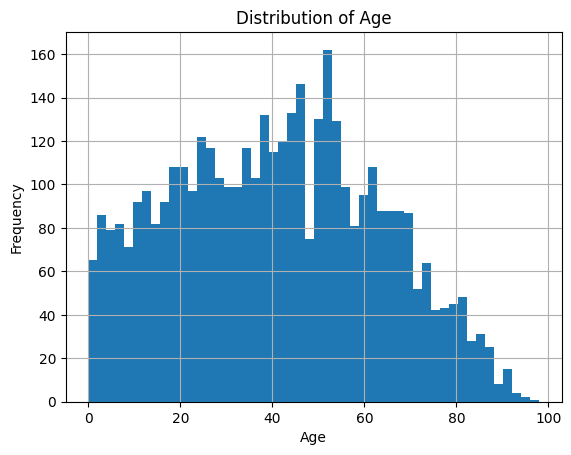

In [119]:
population_local['age'].hist(bins=50)  # Ajuster le nombre de 'bins' selon le besoin
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [163]:
# ranges = ['0-20', '21-40', '41-65', '66-100']
# Création des sous-populations
id_range1 = population_local[(population_local['age'] >= 0) & (population_local['age'] <= 18)]
id_range2_emp = population_local[(population_local['age'] >= 19) & (population_local['age'] <= 35) & (population_local['employed'] == True)]
id_range3_emp = population_local[(population_local['age'] >= 36) & (population_local['age'] <= 65) & (population_local['employed'] == True)]
id_range4_emp = population_local[(population_local['age'] >= 66) & (population_local['age'] <= 100) & (population_local['employed'] == True)]
id_range2_unemp = population_local[(population_local['age'] >= 21) & (population_local['age'] <= 40) & (population_local['employed'] == False)]
id_range3_unemp = population_local[(population_local['age'] >= 41) & (population_local['age'] <= 65) & (population_local['employed'] == False)]
id_range4_unemp = population_local[(population_local['age'] >= 66) & (population_local['age'] <= 100) & (population_local['employed'] == False)]
id_range1.head()

,id,age,home_x,home_y,local,employed,sex,work_start,work_dur,education_start,education_dur,leisure_start,leisure_dur,shop_start,shop_dur
629063,6431926,17,2569878.0,1192664.0,Avenches,False,m,192,43,153,43,245,22,139,4
629826,6600178,7,2569542.0,1192206.0,Avenches,False,m,244,43,154,33,165,16,129,2
629829,6600311,17,2569730.0,1192592.0,Avenches,False,m,192,1,91,46,231,35,195,9
629832,6600384,3,2569106.0,1191963.0,Avenches,False,f,244,103,90,40,184,12,224,2
629845,6601747,6,2569543.0,1192079.0,Avenches,False,f,98,92,92,23,159,22,128,2


In [164]:
def calculate_distributions(sub_population, activity_local_filt):
    '''Fonction pour calculer la distribution des intervalles de temps de début et de durée
    Returns a dictionary distributions['start_time_interval'] = count // distributions['duration_interval'] = count'''
    distributions = {}
    sub_population_ids = sub_population['id'].unique()
    filtered_activities = activity_local_filt[activity_local_filt['id'].isin(sub_population_ids)]

    for activity_type in filtered_activities['type'].unique():
        activity_data = filtered_activities[filtered_activities['type'] == activity_type]
        start_dist = activity_data['start_time_interval'].value_counts(normalize=True)
        duration_dist = activity_data['duration_interval'].value_counts(normalize=True)
        distributions[activity_type] = {'start': start_dist, 'duration': duration_dist}
    
    return distributions

def get_subpopulation_id(person):
    age, employed = person['age'], person['employed']
    if age <= 18:
        return 'range1'
    elif age <= 35:
        return 'range2_emp' if employed else 'range2_unemp'
    elif age <= 65:
        return 'range3_emp' if employed else 'range3_unemp'
    else:
        return 'range4_emp' if employed else 'range4_unemp'

# Calculer les distributions pour chaque sous-population
distributions = {
    'range1': calculate_distributions(id_range1, activity_local_filt),
    'range2_emp': calculate_distributions(id_range2_emp, activity_local_filt),
    'range3_emp': calculate_distributions(id_range3_emp, activity_local_filt),
    'range4_emp': calculate_distributions(id_range4_emp, activity_local_filt),
    'range2_unemp': calculate_distributions(id_range2_unemp, activity_local_filt),
    'range3_unemp': calculate_distributions(id_range3_unemp, activity_local_filt),
    'range4_unemp': calculate_distributions(id_range4_unemp, activity_local_filt),
}
# print(distributions['range4_emp'])

In [171]:
# Initialisation des colonnes pour les durées et heures de début d'activité
for activity_type in activity_types:
    population_local[f'{activity_type}_start'] = 0
    population_local[f'{activity_type}_dur'] = 0

# Pour chaque individu et activity type, choisir aléatoirement un intervalle de temps de début et de durée
for index, person in population_local.iterrows():
    subpop_id = get_subpopulation_id(person)
    for activity_type, dist in distributions[subpop_id].items():
        chosen_start = np.random.choice(dist['start'].index, p=dist['start'].values)
        chosen_duration = np.random.choice(dist['duration'].index, p=dist['duration'].values)
        if subpop_id == 'range1' and activity_type == 'work':
            chosen_start = 0
            chosen_duration = 0
        population_local.at[index, f'{activity_type}_start'] = chosen_start
        population_local.at[index, f'{activity_type}_dur'] = chosen_duration
    
# population_local.sort_values('age').head(30)
# population_local.head(40)